# &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Skin Disease Detection Model 

# Access to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
# Importing some basic libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

# Importing tensorflow libraries 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

<b>Defing directory of Drive</b>

In [ ]:
data_dir = "drive/MyDrive/Skin Disease/"

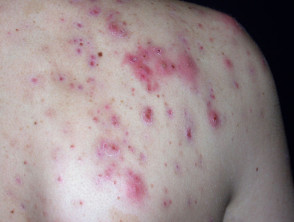

In [ ]:
PIL.Image.open(data_dir + "Acne/Acne (55).jpg")

In [ ]:
# Defining batch size and image size
batch_size = 32
IMG_SIZE = (160, 160)

<b>Reading Training and validation dataset from drive</b>

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            shuffle=True,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed = 123,
                                                            batch_size=batch_size,
                                                            image_size=IMG_SIZE)

Found 4313 files belonging to 4 classes.
Using 3451 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=batch_size)

Found 4313 files belonging to 4 classes.
Using 862 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Acne', 'Eczema', 'Healthy', 'Psoriasis']


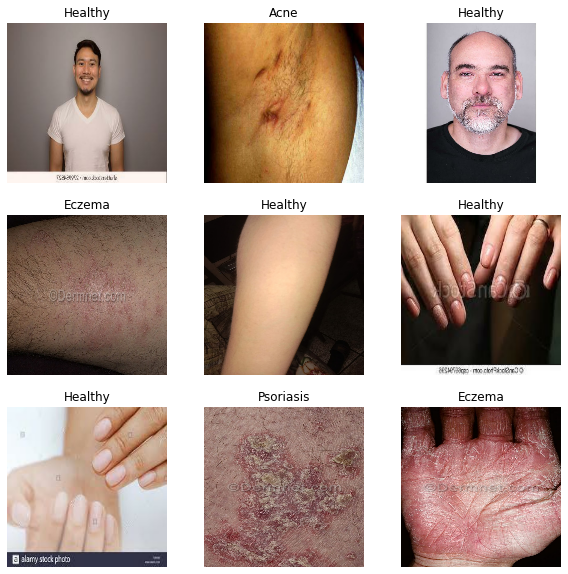

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

<b>Pulling out test set from validation data</b>

In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


<b>Prefetching the data</b>

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

<b>Defining Data Augmentation Layers</b>

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

<b>Defining preprocess layer from mobileNet model</b>

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<b>Defining Callback Checkpoints</b>

In [ ]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


<b>Defining our base model for feature extraction </b>

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(160, 160, 3),
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


<b>Making the layers of base model training false</b>

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

<b>Defining Global Average for immediate use after base model</b>

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


<b>Defining Prediction Layer with 4 classes</b>

In [ ]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation = 'softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


# Defing the Model

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = layers.Dense(512, activation = "relu")(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(256, activation = "relu")(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128, activation = "relu")(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(len(class_names), activation = "softmax")(x)
model = tf.keras.Model(inputs, outputs)

<b>Compiling the model</b>

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=["sparse_categorical_crossentropy"],
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

8

<b>Evaluating model before training</b>

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

22/22 [==============================] - 6s 110ms/step - loss: 1.5345 - accuracy: 0.2479


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.53
initial accuracy: 0.25


<b>Training model on Initial Epochs</b>

In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[cp_callback])

Epoch 1/10
108/108 [==============================] - ETA: 0s - loss: 1.1593 - accuracy: 0.4857
Epoch 1: saving model to training_2/cp.ckpt
108/108 [==============================] - 833s 8s/step - loss: 1.1593 - accuracy: 0.4857 - val_loss: 0.7467 - val_accuracy: 0.7066
Epoch 2/10
107/108 [============================>.] - ETA: 0s - loss: 0.8231 - accuracy: 0.6434
Epoch 2: saving model to training_2/cp.ckpt
108/108 [==============================] - 19s 170ms/step - loss: 0.8209 - accuracy: 0.6445 - val_loss: 0.6518 - val_accuracy: 0.7051
Epoch 3/10
107/108 [============================>.] - ETA: 0s - loss: 0.7439 - accuracy: 0.6618
Epoch 3: saving model to training_2/cp.ckpt
108/108 [==============================] - 19s 167ms/step - loss: 0.7426 - accuracy: 0.6624 - val_loss: 0.6071 - val_accuracy: 0.7293
Epoch 4/10
107/108 [============================>.] - ETA: 0s - loss: 0.7005 - accuracy: 0.6875
Epoch 4: saving model to training_2/cp.ckpt
108/108 [==============================]

<b>Plotting Training and Validation Accuracy on Initial Epochs.</b>

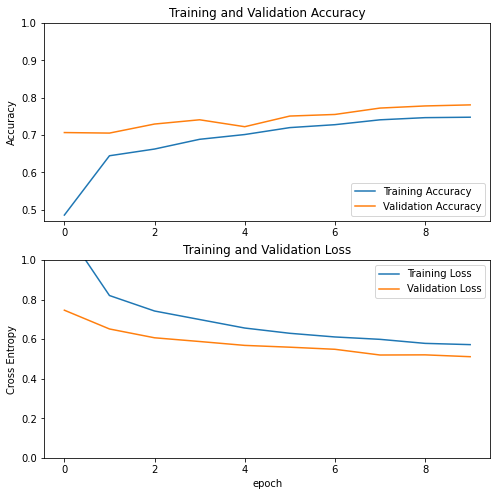

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<b>Making the trainable variable of base model ON.</b>

In [ ]:
base_model.trainable = True

<b>Number of layers in Base Model and start fine tuning after 100 layers.</b>

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


<b>Recompiling the model on different optimizer.</b>

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

62

<b>Training again for 40 more epochs starting from 11th epoch.</b>

In [ ]:
fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[cp_callback])

Epoch 10/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


108/108 [==============================] - ETA: 0s - loss: 0.5782 - accuracy: 0.7430
Epoch 10: saving model to training_2/cp.ckpt
108/108 [==============================] - 29s 192ms/step - loss: 0.5782 - accuracy: 0.7430 - val_loss: 0.5104 - val_accuracy: 0.7493
Epoch 11/50
108/108 [==============================] - ETA: 0s - loss: 0.5317 - accuracy: 0.7691
Epoch 11: saving model to training_2/cp.ckpt
108/108 [==============================] - 21s 183ms/step - loss: 0.5317 - accuracy: 0.7691 - val_loss: 0.4819 - val_accuracy: 0.7806
Epoch 12/50
108/108 [==============================] - ETA: 0s - loss: 0.5190 - accuracy: 0.7792
Epoch 12: saving model to training_2/cp.ckpt
108/108 [==============================] - 21s 183ms/step - loss: 0.5190 - accuracy: 0.7792 - val_loss: 0.4815 - val_accuracy: 0.7806
Epoch 13/50
108/108 [==============================] - ETA: 0s - loss: 0.5070 - accuracy: 0.7879
Epoch 13: saving model to training_2/cp.ckpt
108/108 [==============================] -

<b>Plotting the Training and Validation Accuracy </b>

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

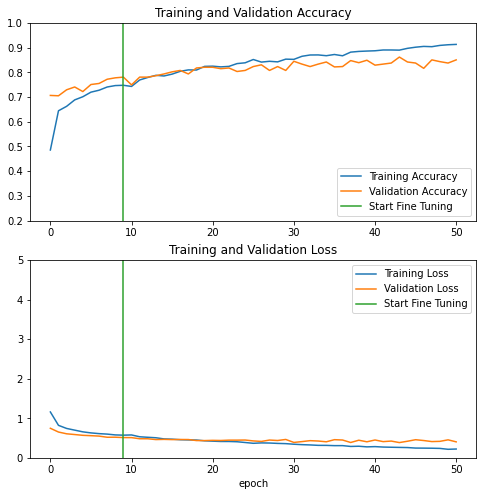

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

<b>Testing the model on Test dataset.</b>

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 2s 130ms/step - loss: 0.4296 - accuracy: 0.8438
Test accuracy : 0.84375


<b>Saving the model.</b>

In [ ]:
model.save("New_4_Classes.h5")